In [156]:
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import warnings
import random
import sklearn.metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings('ignore')

In [5]:
# load the network and centrality
#DiG = nx.read_edgelist(path = "Network-Analysis-Project/citation.edgelist", create_using=nx.DiGraph())
DiG = nx.read_edgelist(path = "../test.edgelist", create_using=nx.DiGraph())

In [7]:
print(nx.info(DiG))

Name: 
Type: DiGraph
Number of nodes: 1553
Number of edges: 2000
Average in degree:   1.2878
Average out degree:   1.2878


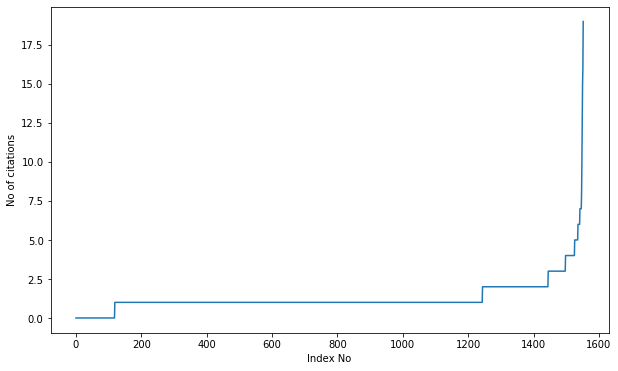

In [86]:
# citations
indegree_dist = list(dict(DiG.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No of citations')
plt.show()

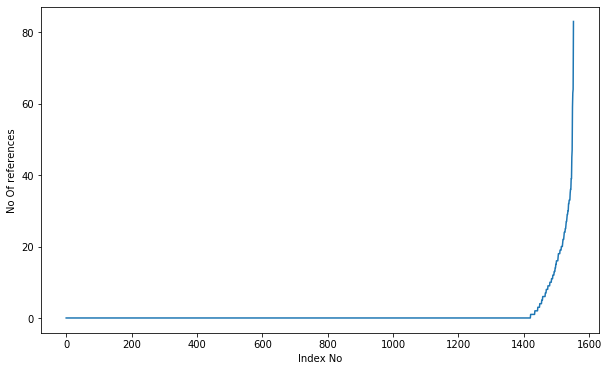

In [87]:
outdegree_dist = list(dict(DiG.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of references')
plt.show()

In [88]:
nEdges = DiG.number_of_edges()

In [92]:
# to create a balance dataset, randomly sample nEdges non-existing edges 
nonEdges = random.sample(list(nx.non_edges(DiG)), nEdges)

In [98]:
print("existing : ", str(nEdges))
print("missing : ", str(len(nonEdges)))

existing :  2000
missing :  2000


In [120]:
#Spiltted data, 80% for training and 20% for testing
#positive links and negative links seperatly, we need positive training data for creating graph

X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(list(DiG.edges()),np.ones(nEdges),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(nonEdges,np.zeros(len(nonEdges)),test_size=0.2, random_state=9)

In [101]:
train_g = nx.DiGraph()
train_g.add_edges_from(X_train_pos)
test_g = nx.DiGraph()
test_g.add_edges_from(X_test_pos)

In [123]:
len(X_train_pos + X_train_neg)

3200

In [124]:
# combine positive and negative edges 
X_train = X_train_pos + X_train_neg
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos + X_test_neg
y_test = np.concatenate((y_test_pos,y_test_neg)) 
       
X_train_df = pd.DataFrame(X_train, columns=["from", "to"])
X_test_df = pd.DataFrame(X_test, columns=["from", "to"])

In [41]:
# jaccard index
# for out neighbors
def jaccard_out(g, a, b):
    try:
        if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
            return 0
        sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/\
                                    (len(set(g.successors(a)).union(set(g.successors(b)))))
    except:
        return 0
    return sim

# for in neighbors 
def jaccard_in(g, a, b):
    try:
        if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/\
                                 (len(set(g.predecessors(a)).union(set(g.predecessors(b)))))
        return sim
    except:
        return 0

In [42]:
# Adar Index
def adar_in(g, a, b):
    sum=0
    try:
        n=list(set(g.successors(a)).intersection(set(g.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(g.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [139]:
# features 
train_f = pd.DataFrame()
test_f = pd.DataFrame()

In [140]:
train_f['jaccard_in'] = X_train_df.apply(lambda row: jaccard_in(train_g, row['from'],row['to']),axis=1)
test_f['jaccard_in'] = X_test_df.apply(lambda row: jaccard_in(test_g, row['from'],row['to']),axis=1)

train_f['jaccard_out'] = X_train_df.apply(lambda row:jaccard_out(train_g, row['from'],row['to']),axis=1)
test_f['jaccard_out'] = X_test_df.apply(lambda row:jaccard_out(test_g, row['from'],row['to']),axis=1)

train_f['adar_in'] = X_train_df.apply(lambda row: adar_in(train_g, row['from'],row['to']),axis=1)
test_f['adar_in'] = X_test_df.apply(lambda row: adar_in(test_g, row['from'],row['to']),axis=1)

In [56]:
def compute_inOut(g, edgeDF):
    in_s=[]
    out_s=[]
    in_d=[]
    out_d=[]
    in_inter=[]
    out_inter=[]
    for i,row in edgeDF.iterrows():
        try:
            s1=set(g.predecessors(row['from']))
            s2=set(g.successors(row['from']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(g.predecessors(row['to']))
            d2=set(g.successors(row['to']))
        except:
            d1 = set()
            d2 = set()
        in_s.append(len(s1))
        out_s.append(len(s2))

        in_d.append(len(d1))
        out_d.append(len(d2))

        in_inter.append(len(s1.intersection(d1)))
        out_inter.append(len(s2.intersection(d2)))
    
    return in_s, in_d, out_s, out_d, in_inter, out_inter

In [142]:
train_f['in_s'], train_f['in_d'], \
train_f['out_s'], train_f['out_d'], \
train_f['in_inter'], train_f['out_inter']= compute_inOut(train_g, X_train_df)


In [143]:
test_f['in_s'], test_f['in_d'], \
test_f['out_s'], test_f['out_d'], \
test_f['in_inter'], test_f['out_inter']= compute_inOut(test_g, X_test_df)

In [145]:
#training the model
param_dist = {"n_estimators":scipy.stats.randint(105,125),
              "max_depth": scipy.stats.randint(10,15),
              "min_samples_split": scipy.stats.randint(110,190),
              "min_samples_leaf": scipy.stats.randint(25,65)}

clf = RandomForestClassifier(random_state=25, n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5, cv=10,scoring='f1',random_state=25)

rf_random.fit(train_f, y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])

#checking the best parameters
print(rf_random.best_estimator_)

mean test scores [0.9586173  0.9588692  0.9589085  0.9586173  0.95889122]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=56, min_samples_split=179,
                       min_weight_fraction_leaf=0.0, n_estimators=106,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [146]:
# bulid the model with best parameters
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=56, min_samples_split=179,
                       min_weight_fraction_leaf=0.0, n_estimators=106,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [157]:
# Evaluation
clf.fit(train_f, y_train)
y_train_pred = clf.predict(train_f)
y_test_pred = clf.predict(test_f)
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)

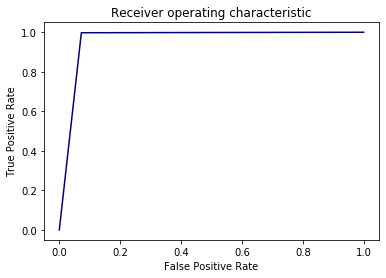

In [159]:
# plot ROC curve
plt.clf()
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.savefig("ROC.png", dpi=200)